In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import json

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images

from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle

from mrcnn.config import Config

from mrcnn.model import MaskRCNN
from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw
from mrcnn import visualize

Using TensorFlow backend.


In [2]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [3]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/home/ubuntu/catkin/lane_segmentation/training/annotations.json', '/home/ubuntu/catkin/lane_segmentation/training/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/home/ubuntu/catkin/lane_segmentation/training/annotations.json', '/home/ubuntu/catkin/lane_segmentation/training/')
dataset_val.prepare()

In [4]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "lane_segmentation"
    # number of classes (background + lane)
    NUM_CLASSES = 1 + 1
    # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [5]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [6]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)
# load model weights
model.load_weights('/home/ubuntu/Workspace/Mask_RCNN/logs/lane_segmentation20230505T0903/mask_rcnn_lane_segmentation_0009.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(dataset_train, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(dataset_val, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Re-starting from epoch 9
Train mAP: 1.000
Test mAP: 1.000


Processing 1 images
image                    shape: (240, 320, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


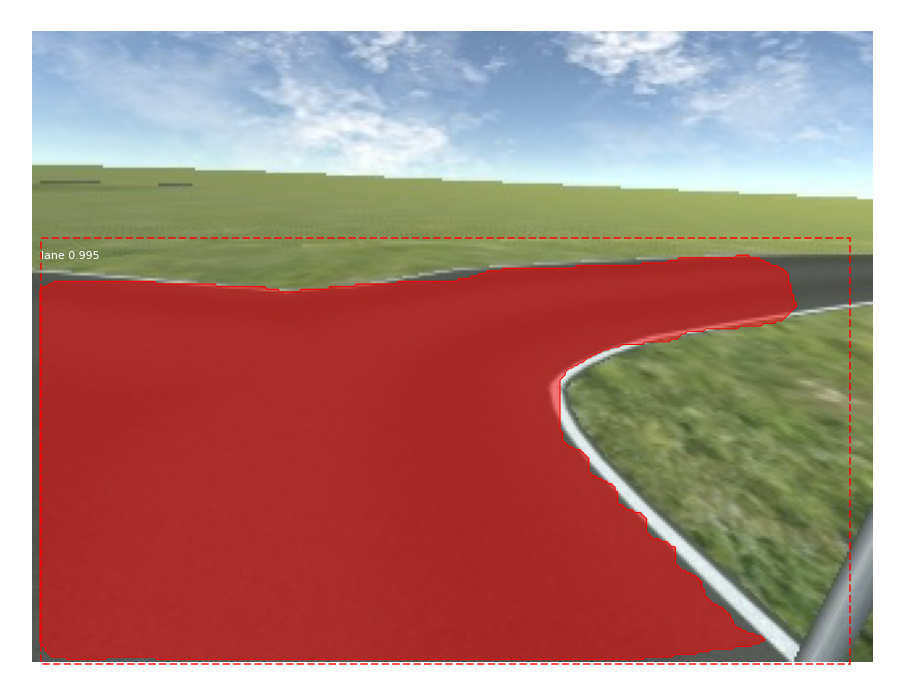

In [7]:
#Test on a single image
lane_img = skimage.io.imread("/home/ubuntu/catkin/lane_segmentation/validate/savedImage1095.jpg")
# plt.imshow(lane_img)

# detected = model.detect([lane_img])
# results = detected[0]
class_names = ['BG', 'lane']
# display_instances(lane_img, results['rois'], results['masks'], 
#                   results['class_ids'], class_names, results['scores'])
results = model.detect([lane_img], verbose=1)

# # Visualize results
r = results[0]
visualize.display_instances(lane_img, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [8]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 128
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash

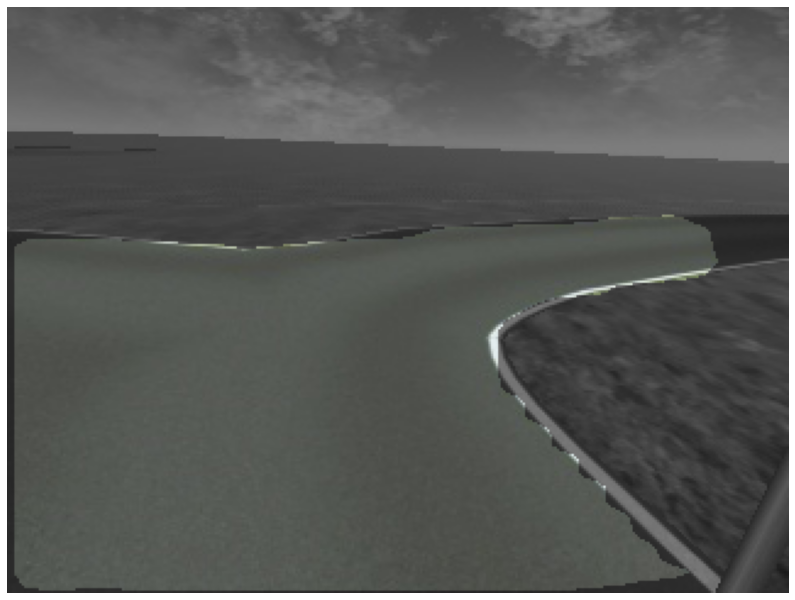

In [9]:
splash = color_splash(lane_img, r['masks'])
display_images([splash], cols=1)

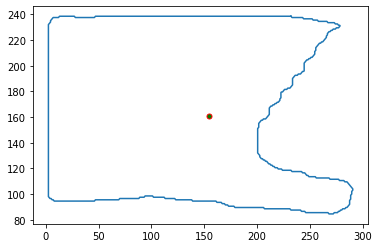

In [10]:
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt


def save_co_ordinates(image, boxes, masks, class_ids, class_names):
    image = image.split("/")[-1]
    image_data = []

    for i in range(boxes.shape[0]):

        class_id = class_ids[i]
        label = class_names[class_id]

        mask = masks[:, :, i]
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            verts = np.fliplr(verts) - 1
            list_co_ordinates = np.moveaxis(verts, 1, 0).tolist()

            region = {"shape_attributes": {"all_points_x": list_co_ordinates[0],
                                           "all_points_y": list_co_ordinates[1]},
                      "region_attributes": {"name": {label: True}}}
            image_data.append(region)
    data = image_data
    return data

shapes = save_co_ordinates("/home/ubuntu/catkin/lane_segmentation/validate/savedImage1112.jpg", r['rois'], r['masks'], r['class_ids'], class_names)

x_cor = None
y_cor = None

plt.figure()
for shape in shapes:
    if shape is not None:
        x_cor = shape['shape_attributes']['all_points_x']
        y_cor = shape['shape_attributes']['all_points_y']
        plt.plot(x_cor+x_cor[:1], y_cor+y_cor[:1])
        
x = [p for p in x_cor]
y = [p for p in y_cor]
centroid = [(sum(x) / len(x_cor)), (sum(y) / len(y_cor))]
plt.plot(centroid[0], centroid[1], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
plt.show()